Recipe for peak-fitting in a way that handles Bayesian block boundary effects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from xrdc import xrdutils
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc import visualization as vis
from xrdc import peak_fitting as pf
from xrdc import workflows
from xrdc import geometry
from xrdc import plotting
from xrdc import refinement
from xrdc import misc

from scipy.ndimage.filters import gaussian_filter as gf
from matplotlib.pyplot import figure

from copy import deepcopy as dc

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


In [2]:
basepath = "../../../datasets/nate/casettes/"

from glob import glob
import os

paths = glob(basepath + '*csv')

datasets = ([pd.read_csv(p) for p in paths])

In [3]:
threshold = 15
bg_smooth = 0
bg_smooth_post = 20

patterns = pd.DataFrame(d['I'] for d in datasets)
patterns = patterns.values

background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')

(0, 0)


In [4]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)

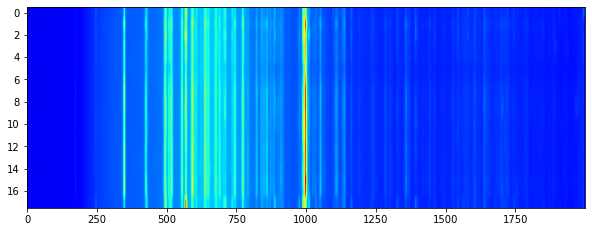

In [5]:
plt.imshow(patterns, aspect = 40, cmap = 'jet')

In [6]:
%matplotlib inline
sep.iplot_rows(patterns, fast_q, background, labels = ['raw', 'extracted'])

interactive(children=(IntSlider(value=8, description='i', max=17), Output(layout=Layout(height='550px'))), _do…

In [7]:
np.random.seed(42)
noise = aggregate_uncertainty[:, None].T


In [8]:
def mean2d(arr2d):
    return arr2d.mean(axis = 0)[:, None].T

In [9]:
def restrict_range(fitlists_merged, fitlists_single, offset = 1, clip = True):
    suby, _, noiseListNew, xListNew, yListNew, _ = fitlists_single
    _, summaryList, _, _, _, curve_paramsList = fitlists_merged
    
    def take(arr):
        if clip:
            return np.array(misc.deepmap(arr, lambda arr: arr[offset:-offset], 1))
        else:
            return np.array(arr)#misc.deepmap(arr, lambda arr: arr, 1))
    return suby, summaryList, take(noiseListNew), take(xListNew), take(yListNew), curve_paramsList


def filter_peaks_and_restrict_range(fitlists_merged, fitlists_single, bounds, offset = 1, clip_edges = True):
    filt = refinement.filter_peaks(fitlists_merged, bounds, 0, boundoffset = 1, buffer = 0.5, clip_edges = clip_edges)
    return restrict_range(filt, fitlists_single, clip = clip_edges)

In [75]:
stdratio_threshold = 6
pf.cfg['fitInfo']['numCurves'] = 4 # fit up to 4 curves per block
background_agg = mean2d(background)[0]
patterns_agg = mean2d(patterns - 0)[0]

noise = aggregate_uncertainty[:, None].T
def curvefit_2d_refine(patterns, background, noise, overlap = 3, i = 0):
    # fit_sigma = True passes the estimated uncertainty to scipy.fit_curve
    patterns = patterns[None, :]
    background = background[None, :]
    fsub_stop_2d_1 = pf.curvefit_2d(patterns, stdratio_threshold = stdratio_threshold,\
                                    noise_estimate = noise, background = background,\
                                    bg_shift_pos = True, fit_sigma = True, reg_scale = 1e-1, reg_edge = 0);

    i, j = 0, 0
    x, y, X, Y, ys, bounds = pf.get_curves(fsub_stop_2d_1, 0, j, peak_range_only=False)

    fsub_stop_2d_1_filt = refinement.filter_peaks(fsub_stop_2d_1, bounds, 0, boundoffset = 0, buffer= .5,
                                                 clip_edges = False)

#     fsub_stop_2d_3 = pf.merge_fitoutput_blocks(fsub_stop_2d_1_filt, overlap = overlap)
#     fsub_stop_2d_3 = pf.refine_2d((patterns - background),
#                         pf.merge_fitoutput_blocks(fsub_stop_2d_1_filt, overlap = overlap),\
#                         noise_estimate = noise, background = None,\
#                         bg_shift_pos = True, fit_sigma = True, reg_scale = 1e-1, reg_edge = 0,
#                         overlap = overlap, bounds = bounds)

#     fsub_stop_2d_3_cropped = filter_peaks_and_restrict_range(fsub_stop_2d_3, fsub_stop_2d_1, bounds, clip_edges=True)
#     #XX, YY = refinement.get_tails(fsub_stop_2d_3, bounds, 0, 1, background = background)
    return fsub_stop_2d_1, fsub_stop_2d_1_filt#, fsub_stop_2d_3_cropped

In [72]:
reload(refinement.plotting)
reload(plotting)
reload(refinement)
reload(pf.hitp)
reload(pf)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


<module 'xrdc.peak_fitting' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/peak_fitting.py'>

In [33]:
%pdb

Automatic pdb calling has been turned OFF


In [76]:
fits_init, fits_filtered = curvefit_2d_refine(patterns_agg, background_agg, noise)

numBlocks: 47, dataPts/Block: 42.5531914893617
[   0.  353.  488.  513.  551.  558.  572.  635.  653.  714.  749.  837.
  972. 1100. 1999.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 353.0], [353.0, 488.0], [488.0, 513.0], [513.0, 551.0], [551.0, 558.0], [558.0, 572.0], [572.0, 635.0], [635.0, 653.0], [653.0, 714.0], [714.0, 749.0], [749.0, 837.0], [837.0, 972.0], [972.0, 1100.0], [1100.0, 1999.0]]}
negative values in background-subtracted pattern. shifting to create all non-negative values.
global background
[-1.00890563e+01 -1.00146422e+01 -9.80297602e+00 -6.44822210e+00
 -1.82947125e+00  1.68872411e+00  4.31022562e+00  5.28475056e+00
  4.76407593e+00  4.00031643e+00  3.30775437e+00  3.50618644e+00
  3.90775902e+00  4.65325741e+00  4.62853091e+00  3.54034172e+00
  2.98033381e+00  3.07518189e+00  3.83451140e+00  3.71502573e+00
  2.71667985e+00  1.52673678e+00  2.65207528e-01 -1.04304132e+00
 -1.82853226e+00 -2.27458355e+00 -1.74987887e+00 -1.48444315e+00
 -1.49704416e+

peak fit kwargs {'stdratio_threshold': 6, 'fit_sigma': True, 'reg_scale': 0.1, 'reg_edge': 0}
Peak at 427, start iteration with error = 0.6891316533550008
56.62553912395594
[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 427, iteration 0: error = 0.41829656662067943
16.647870751866208
[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 40

/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


peak fit kwargs {'stdratio_threshold': 6, 'fit_sigma': True, 'reg_scale': 0.1, 'reg_edge': 0}
Peak at 594, start iteration with error = 0.5972723404611611
16.56567974285116
[572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634]
Peak at 594, iteration 0: error = 0.3955523303471918
6.052926286001204
[572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634]
Peak at 594, iteration 1: error = 0.42667988857412176
2.9241731949963805
bounds ([568.9, -104.54089768393787, 0, 0, 0, 568.9, -104.54089768393787, 0, 0, 0], [637.1, inf, inf, 62.0, 62.0, 637.1, inf, inf, 62.0, 62.0])
[572 573 574 575 576 577 

peak fit kwargs {'stdratio_threshold': 6, 'fit_sigma': True, 'reg_scale': 0.1, 'reg_edge': 0}
Peak at 999, start iteration with error = 0.9365624388252691
78.9182681851621
[ 972  973  974  975  976  977  978  979  980  981  982  983  984  985
  986  987  988  989  990  991  992  993  994  995  996  997  998  999
 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099]
Peak at 999, iteration 0: error = 1.4165948217157727
19.53169126768951
[ 972  973  974  975  976  977  978  979  980  981  982  983  984  985
  986  987  988  989  990  991  992

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 1109, iteration 2: error = 0.6561877271146451
15.298895220795922
[1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111 1112 1113
 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126 1127
 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140 1141
 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154 1155
 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168 1169
 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183
 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197
 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211
 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225
 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239
 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253
 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265

    ----Saving data for block between 1.00 - 352.00
    ----Saving data for block between 353.00 - 487.00
    ----Saving data for block between 488.00 - 512.00
    ----Saving data for block between 513.00 - 550.00
    ----Saving data for block between 551.00 - 557.00
    ----Saving data for block between 558.00 - 571.00
    ----Saving data for block between 572.00 - 634.00
    ----Saving data for block between 635.00 - 652.00
    ----Saving data for block between 653.00 - 713.00
    ----Saving data for block between 714.00 - 748.00
    ----Saving data for block between 749.00 - 836.00
    ----Saving data for block between 837.00 - 971.00
    ----Saving data for block between 972.00 - 1099.00
    ----Saving data for block between 1100.00 - 1998.00
done
initial peak count: 40
final peak count: 34


In [16]:
%pdb

Automatic pdb calling has been turned OFF


<IPython.core.display.Javascript object>


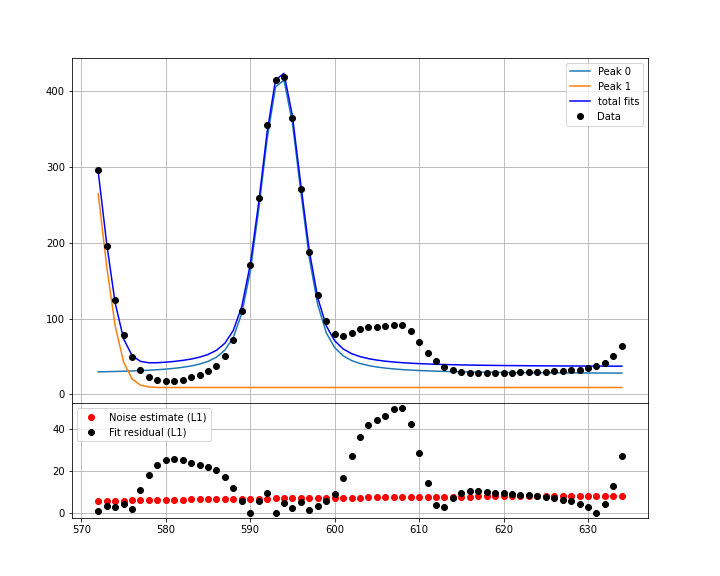

In [77]:
plotting.plot_one_fit(fits_init, 0, 6);

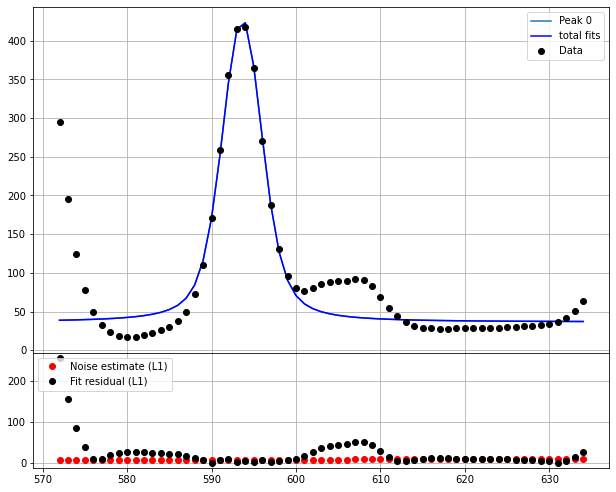

In [68]:
plotting.plot_one_fit(fits_filtered, 0, 6);

In [144]:
# XX, YY = refinement.get_tails(fsub_stop_2d_3, bounds, 0, 1, background = background)

initial peak count: 209
final peak count: 142
-1.602333888274591
-0.8041093317974823
0.010171610557529576
0.8168773592367984
-0.9858496993062076
-1.8182514138725665
-8.33147916026936
7.881402724440335
45.6380943318141
39.24284157521804
24.061556340625764
13.297552514733809
12.914614076232759
23.47425049420396
17.71492694344471
-7.207237029183105
-12.284517729758363
-11.68063745519231
-4.509107544251915
2.030608277286589
13.976753087602972
37.890915111247196
20.061216559868562
-13.060287552236725
-13.991654515174876
-23.469538410214767
-5.783052710829473
9.698991326853132
5.701238216909566
4.813034455490836
-9.6118385863208
-0.17779335393707996
-1.7068455025266926
-2.120679192416686
-3.6675195010095365
-1.4601277232894994
-4.698356912597788
-4.2363057217202025
6.418621790650113
1.4570853753801014
5.682999420306183
-7.467531402141376
-1.85642591882036
-2.4145022290480886
0.02493046164016466
-0.08574192260534375
-6.633532272807579
-4.479467632173602
-2.9744670159511917
-1.4983229453888178

NameError: name 'fsub_stop_2d_3_filt' is not defined

> <ipython-input-144-12de9c692ffe>(5)<module>()
      1 XX, YY = refinement.get_tails(fsub_stop_2d_3, bounds, 0, 1, background = background)
      2 
      3 
      4 
----> 5 fsub_stop_2d_3_filt_cropped = restrict_range(fsub_stop_2d_3_filt, fsub_stop_2d_1)

ipdb> c


<IPython.core.display.Javascript object>


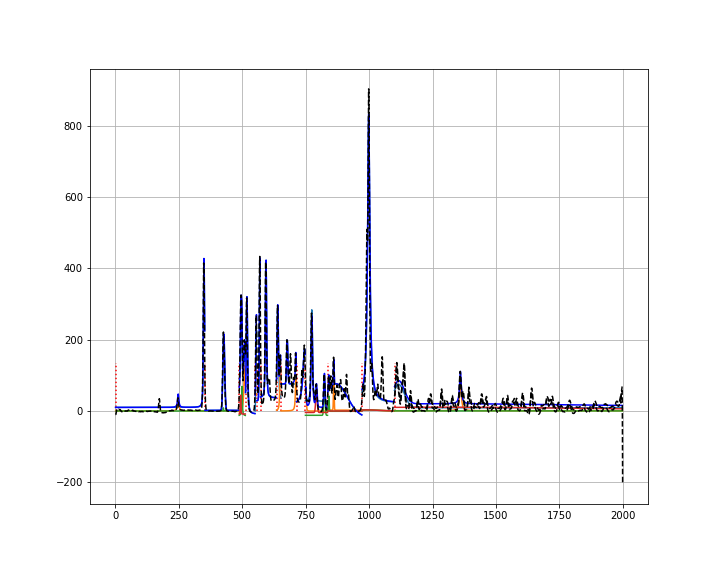

In [74]:
%matplotlib notebook
plotting.plot_all_fits(fits_filtered, 0);
plt.plot(mean2d(patterns - background)[0], 'k--')
#plt.plot(XX, YY, 'o')

(-25.0, 200.0)

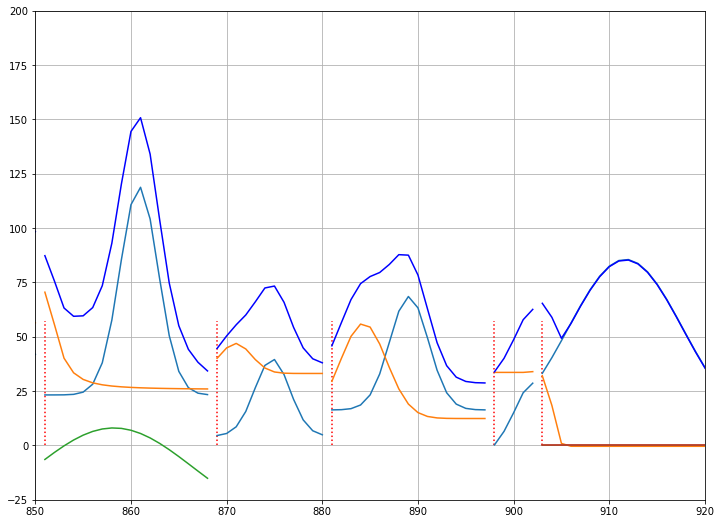

In [67]:
plotting.plot_all_fits(fits_init, 0);
plt.xlim(850, 920)
plt.ylim(-25, 200)

(-25.0, 200.0)

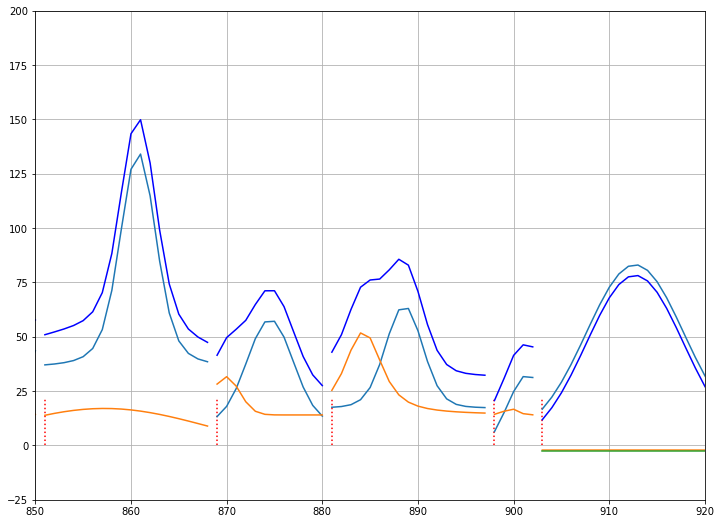

In [66]:
plotting.plot_all_fits(fits_refined, 0);
plt.xlim(850, 920)
plt.ylim(-25, 200)

In [64]:
def pad_fits(fits1, fits2, size = 1):
    def _padlist(lst1, lst2):
        return [lst2[:size]] + lst1 + [lst2[-size:]]
    res = [fits1[0]]
    for lst1, lst2 in zip(fits1[1:], fits2[1:]):
        res.append(_padlist(lst1, lst2))
    return res

# Interactive plots

interactive(children=(IntSlider(value=27, description='i', max=55), Output(layout=Layout(height='550px'))), _d…

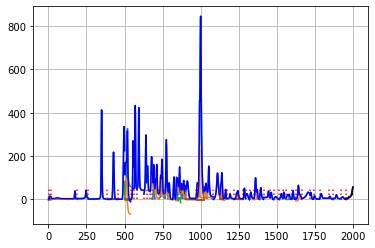

In [57]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_init, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])

interactive(children=(IntSlider(value=26, description='i', max=52), Output(layout=Layout(height='550px'))), _d…

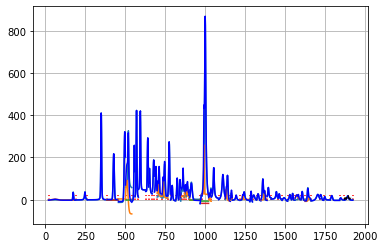

In [58]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_refined, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])